In [1]:
TRADE_API_KEY = "PK5B3YR9A6ISYPHBQHQK"
TRADE_API_SECRET = "3rkXqNhvceXOgf1TpNIlF4QSaphC0zAQf4uWmvSO"

In [2]:
PAPER=True 
TRADE_API_URL=None
TRADE_API_WSS=None
DATA_API_URL=None
OPTION_STREAM_DATA_WSS=None

In [3]:
api_key = TRADE_API_KEY
secret_key = TRADE_API_SECRET
paper = PAPER
trade_api_url = TRADE_API_URL

In [4]:
import json
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

import alpaca
from alpaca.data.live.stock import *
from alpaca.data.historical.stock import *
from alpaca.data.requests import *
from alpaca.data.timeframe import *
from alpaca.trading.client import *
from alpaca.trading.stream import *
from alpaca.trading.requests import *
from alpaca.trading.enums import *
from alpaca.common.exceptions import APIError

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pandas.plotting import scatter_matrix
%matplotlib inline
from tqdm import tqdm


In [5]:
stock_historical_data_client = StockHistoricalDataClient(api_key, secret_key, url_override=DATA_API_URL)

In [6]:
req = StockBarsRequest(
    symbol_or_symbols="TLRY",
    timeframe=TimeFrame(amount=1, unit=TimeFrameUnit.Day), # specify timeframe
    start=datetime.now() - timedelta(days=14),                          # specify start datetime, default=the beginning of the current day.
    # end_date=None,                                        # specify end datetime, default=now
    limit=180000,                                               # specify limit
)

data = stock_historical_data_client.get_stock_bars(req).df
data.reset_index().set_index('timestamp')
display(data)

open  high     low   close       volume  \
symbol timestamp                                                              
TLRY   2025-01-28 05:00:00+00:00  1.1100  1.11  1.0700  1.0900   27784114.0   
       2025-01-29 05:00:00+00:00  1.0800  1.11  1.0300  1.0400   61394631.0   
       2025-01-30 05:00:00+00:00  1.0700  1.15  1.0500  1.1300   45659663.0   
       2025-01-31 05:00:00+00:00  1.1300  1.14  1.0400  1.0500   38419195.0   
       2025-02-03 05:00:00+00:00  0.9902  1.02  0.9715  0.9900   53834080.0   
       2025-02-04 05:00:00+00:00  0.9950  1.05  0.9800  1.0000   38237052.0   
       2025-02-05 05:00:00+00:00  1.0300  1.20  1.0101  1.0700  114368673.0   
       2025-02-06 05:00:00+00:00  1.0700  1.13  1.0300  1.0600   62162006.0   
       2025-02-07 05:00:00+00:00  1.0400  1.06  0.9903  1.0000   66129228.0   
       2025-02-10 05:00:00+00:00  1.0100  1.01  0.9400  0.9805   80243561.0   

                                  trade_count      vwap  
symbol timestamp                                         
TLRY   2025-01-28 05:00:00+00:00      24923.0  1.093143  
       2025-01-29 05:00:00+00:00      34786.0  1.062078  
       2025-01-30 05:00:00+00:00      27396.0  1.095633  
       2025-01-31 05:00:00+00:00      26857.0  1.079988  
       2025-02-03 05:00:00+00:00      47043.0  0.997106  
       2025-02-04 05:00:00+00:00      29759.0  1.005561  
       2025-02-05 05:00:00+00:00      73767.0  1.109418  
       2025-02-06 05:00:00+00:00      42034.0  1.081856  
       2025-02-07 05:00:00+00:00      63852.0  1.006105  
       2025-02-10 05:00:00+00:00      65183.0  0.971458

<div style='font-size: 40px;'>Model Training</div>


In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import ta
import seaborn as sns


In [8]:
def load_stock2(ticker, start, end = None, interval_type = TimeFrameUnit.Minute, interval_length = 1, mean_period = 20, std = 2):
    
    req = StockBarsRequest(
    symbol_or_symbols=ticker,
    timeframe=TimeFrame(amount=interval_length, unit=interval_type), # specify timeframe
    start=start,                          # specify start datetime, default=the beginning of the current day.
    # end_date=None,                                        # specify end datetime, default=now
    #limit=None,                                               # specify limit
    )
    
    hist = stock_historical_data_client.get_stock_bars(req).df
    hist = hist.reset_index().set_index('timestamp')
    
    #n is the number of periods
    n=mean_period
    
    #SMA
    #hist['n_mean'] = [hist['close'][i-19:i+1].mean() for i in range(len(hist))]

    #EMA
    hist['n_mean'] = hist['close'].ewm(span=n, adjust=False).mean()
    
    
    #bollingers
    
    std_setting = std
    
    hist['n_std'] = [np.std(hist['close'][i-n+1:i+1]) for i in range(len(hist))]
    hist['n-BU'] = [hist['n_mean'].iloc[i] + std_setting * hist['n_std'].iloc[i] for i in range(len(hist))]
    hist['n-BL'] = [hist['n_mean'].iloc[i] - std_setting * hist['n_std'].iloc[i] for i in range(len(hist))]
    
    #focus################
        #focus_start = '2024-03-04 09:30:00-05:00'
        #focus_end = '2024-03-12 16:00:00-05:00'
    focus = hist.copy()#loc[focus_start:focus_end].copy()
        
    #focus.loc[:,'outside'] = (focus['close']<focus[f'{n}-BL']) | (focus['close']>focus[f'{n}-BU'])
    focus.loc[:,'under'] = focus['close']<focus['n-BL']
    focus.loc[:,'signal'] = [(focus['under'].iloc[i] == True) & (focus['under'].iloc[i-1] == False) for i in range(len(focus))]
    
    #signals################
    signals = focus[focus['signal'] == 1]

    return hist, focus, signals

In [9]:
def simulate2(focus, signals, loss_threshold = 0.98):

    #maker_fee = 0.0015
    #taker_fee = 0.0025
    
    focus = focus.reset_index()
    signal_on = False
    growth = 1.0
    growth_vals = np.array([])
    buy_price = 0
    sell_price = 0
    curr_buy_i = 0
    focus['buy_result'] = np.zeros(focus.shape[0])
    
    def open_order(i):
        signal_on = True
        buy_price = focus['close'].iloc[i]
        curr_buy_i = i
        return signal_on, buy_price, curr_buy_i
    
    def close_order(i, growth_vals, growth):
        sell_price = focus['close'].iloc[i]
        ratio = sell_price/buy_price
        growth_vals = np.append(growth_vals, ratio)
        growth = growth * ratio
        signal_on = False
        return signal_on, growth, growth_vals
        
    for i in range(len(focus)):
    
        if focus['signal'].iloc[i] == True:
            if signal_on == False:
                signal_on, buy_price, curr_buy_i = open_order(i)
    
        if signal_on == True:
            if focus['close'].iloc[i] >= focus['n_mean'].iloc[i]:
                signal_on, growth, growth_vals = close_order(i, growth_vals, growth)
                if focus['close'].iloc[i] > buy_price:
                    focus.at[curr_buy_i, 'buy_result'] = 1 

            #risk mitigation; sell if drop more than n% from buy price
            elif focus['close'].iloc[i] < loss_threshold*buy_price:
                signal_on, growth, growth_vals = close_order(i, growth_vals, growth)
                
            #elif focus.index.time == pd.Timestamp('15:59:00').time():
                #signal_on, growth, growth_vals = close_order(i, growth_vals, growth)
    
    focus = focus.set_index('timestamp')
    
    #print('growth: ',(growth - 1)*100,'%')
    #print('growth mean: ',np.mean(growth_vals))
    #print('growth max: ',max(growth_vals))
    return growth, growth_vals, focus

In [10]:
def calculate_rsi(prices, period=14):
    """
    Calculate the Relative Strength Index (RSI) for a given time series array of stock prices.

    Args:
    - prices (list): A list of stock prices in chronological order.
    - period (int): The time period over which to calculate the RSI. Default is 14.

    Returns:
    - rsi_values (list): An array of RSI values corresponding to the input prices.
    """
    if len(prices) < period:
        raise ValueError("Length of prices array should be greater than or equal to the period.")

    delta = [prices[i + 1] - prices[i] for i in range(len(prices) - 1)]
    gain = [d if d > 0 else 0 for d in delta]
    loss = [abs(d) if d < 0 else 0 for d in delta]

    avg_gain = sum(gain[:period]) / period
    avg_loss = sum(loss[:period]) / period

    rsi_values = [None] * period

    rs = avg_gain / avg_loss if avg_loss != 0 else float('inf')
    rsi_values.append(100 - (100 / (1 + rs)))

    for i in range(period, len(prices) - 1):
        avg_gain = (avg_gain * (period - 1) + gain[i]) / period
        avg_loss = (avg_loss * (period - 1) + loss[i]) / period
        rs = avg_gain / avg_loss if avg_loss != 0 else float('inf')
        rsi_values.append(100 - (100 / (1 + rs)))

    return rsi_values

In [11]:
def calculate_adx(focus, window=14):
    """
    Calculate ADX (Average Directional Index) values for a given time series array of close prices.

    Args:
    close_prices (list or numpy array): Time series array of close prices.
    window (int): Window size for calculating ADX. Default is 14.

    Returns:
    adx_values (numpy array): Array of ADX values of the same length as input array.
    """
    # Initialize ADX indicator
    adx_indicator = ta.trend.ADXIndicator(high=focus['high'], low=focus['low'], close=focus['close'], window=window)

    # Calculate ADX values
    adx_values = adx_indicator.adx()

    return adx_values

In [12]:
def calculate_macd(close_prices):
    # Create a DataFrame with the close prices
    df = pd.DataFrame({'close': close_prices})
    
    # Calculate MACD using ta package
    df['macd'] = ta.trend.macd_diff(df['close'])
    
    # Extract MACD values
    macd_values = df['macd'].values
    
    return macd_values


# SET TRAINING STOCK AND PERIOD

In [62]:
#START AND END TIME
########################
length = 1825
start_time = datetime.now() - timedelta(days=length)

training_stock = 'BB'


In [63]:
hist, focus, signals = load_stock2(training_stock, start_time, interval_type = TimeFrameUnit.Hour, interval_length = 1, mean_period = 20, std=1.75)

In [64]:
focus['RSI'] = calculate_rsi(np.array(focus['close']))
focus['ADX'] = calculate_adx(focus)
focus['MACD'] = calculate_macd(np.array(focus['close']))
focus['3-p slope'] = [focus['close'].iloc[i-3] - focus['close'].iloc[i] for i in range(len(focus))]
focus['5-p slope'] = [focus['close'].iloc[i-4] - focus['close'].iloc[i] for i in range(len(focus))]
focus['9-p slope'] = [focus['close'].iloc[i-9] - focus['close'].iloc[i] for i in range(len(focus))]
focus['14-p slope'] = [focus['close'].iloc[i-14] - focus['close'].iloc[i] for i in range(len(focus))]

focus['diff'] = focus['close']-focus['n_mean']

In [65]:
growth, growth_vals, sim_focus = simulate2(focus, signals)
sim_signals = sim_focus[sim_focus['signal'] == True]
#sim_signals
int1 = sim_signals.drop(columns=['symbol','close','open','vwap','n_mean','high','low','n-BU','n-BL','under','signal'])
int1 = int1.fillna(0)
display(int1.head())
int1.shape

,volume,trade_count,n_std,RSI,ADX,MACD,3-p slope,5-p slope,9-p slope,14-p slope,diff,buy_result
timestamp,,,,,,,,,,,,
2020-02-14 18:00:00+00:00,997150.0,2052.0,0.066498,22.605044,0.000000,0.000000,0.120,0.1681,0.205,0.2150,-0.167205,1.0
2020-02-21 14:00:00+00:00,552611.0,1760.0,0.039207,42.763430,22.091292,-0.012294,0.080,0.1100,0.170,0.0802,-0.086142,0.0
2020-02-24 12:00:00+00:00,2643.0,11.0,0.093836,32.857193,23.834438,-0.023295,0.190,0.1600,0.220,0.3300,-0.214553,0.0
2020-02-25 15:00:00+00:00,2147178.0,4492.0,0.107825,31.951718,32.362421,0.000842,0.175,0.2650,0.090,0.1750,-0.190254,0.0
2020-02-25 17:00:00+00:00,646001.0,1715.0,0.116038,27.264195,33.820550,-0.013629,0.250,0.2750,0.210,0.2123,-0.244924,0.0


(613, 12)

In [ ]:
#features: std, max std in past 7 periods, volume, 3-slope, 7-slope, 20-slope
print('Default Model')
train, val = train_test_split(int1, test_size = 0.1, random_state = 42)

y_train = np.array(train['buy_result'])
x_train = train.drop(columns = ['buy_result']).values
y_val = np.array(val['buy_result'])
x_val = val.drop(columns = ['buy_result']).values

model = LogisticRegression(
        fit_intercept=True,
        penalty='l2',
        max_iter=10000)

model.fit(x_train, y_train)

train_probs = model.predict_proba(x_train)[:, 1]  # Probabilities of positive class (class 1)
val_probs = model.predict_proba(x_val)[:, 1]

# Define your threshold (e.g., 0.5 for the default threshold)
threshold = 0.5

# Apply threshold for classification
train_pred = (train_probs > threshold).astype(int)
val_pred = (val_probs > threshold).astype(int)

training_accuracy = sum(train_pred==y_train)/len(y_train)
val_accuracy = sum(val_pred==y_val)/len(y_val)
one_predictor_accuracy = sum(1==y_train)/len(y_train)

print("One Predictor Accuracy: ", one_predictor_accuracy)
print("Training Accuracy: ", training_accuracy)
print("Validation Accuracy: ", val_accuracy)

print("Increase in accuracy:", round((((val_accuracy+training_accuracy)/2)/one_predictor_accuracy - 1)*100,2),"%")
print()

Default Model
One Predictor Accuracy:  0.4537205081669691
Training Accuracy:  0.5952813067150635
Validation Accuracy:  0.532258064516129
Increase in accuracy: 24.25 %



### See which feature removal is beneficial

In [67]:
run = False

if run == True:
    for i in int1.columns:
    
        print(i)
        if i == 'buy_result':
            continue
        
        int2 = int1
        int2 = int2.drop(columns=i)
        
        train, val = train_test_split(int2, test_size = 0.1, random_state = 42)
        
        y_train = np.array(train['buy_result'])
        x_train = train.drop(columns = ['buy_result']).values
        y_val = np.array(val['buy_result'])
        x_val = val.drop(columns = ['buy_result']).values
        
        model = LogisticRegression(
                fit_intercept=True,
                penalty='l2',
                max_iter=50000)
        
        model.fit(x_train, y_train)
        
        train_pred = model.predict(x_train)
        val_pred = model.predict(x_val)
        
        training_accuracy = sum(train_pred==y_train)/len(y_train)
        val_accuracy = sum(val_pred==y_val)/len(y_val)
        one_predictor_accuracy = sum(1==y_train)/len(y_train)
        
        print("One Predictor Accuracy: ", one_predictor_accuracy)
        print("Training Accuracy: ", training_accuracy)
        print("Validation Accuracy: ", val_accuracy)
        
        print("Increase in accuracy:", round((((val_accuracy+training_accuracy)/2)/one_predictor_accuracy - 1)*100,2),"%")
        print()


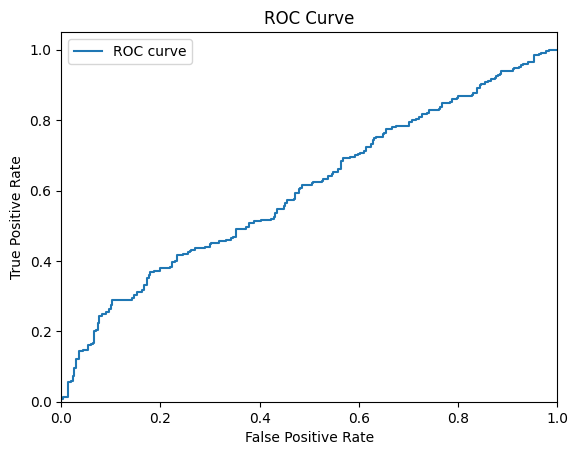

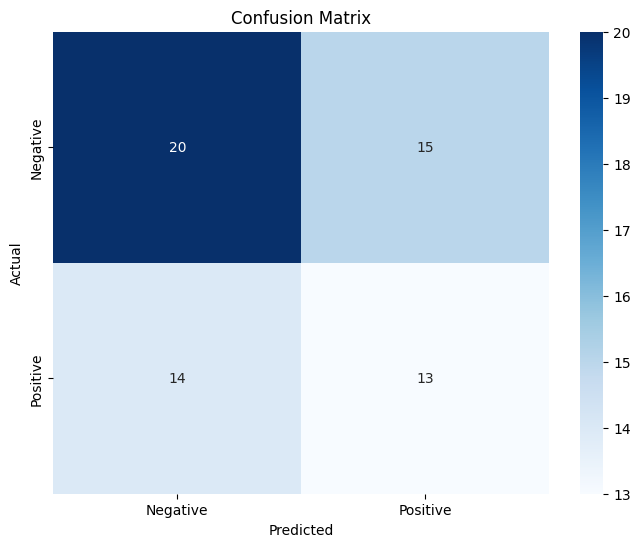

In [68]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.metrics import confusion_matrix

#ROC Curve
probs = model.predict_proba(x_train)
preds = probs[:,1]

false_pos_rate, true_pos_rate, threshold = roc_curve(y_train, preds)
ROC = auc(false_pos_rate, true_pos_rate)

plt.figure()
plt.plot(false_pos_rate, true_pos_rate, label='ROC curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.show()

#CONFUSION MATRIX
# Example ground truth and predicted labels
true_labels = y_val
predicted_labels = val_pred

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [69]:
#threshold vs growth

#AAPL optimal for 5o day is 0.225

length = 730
start_time = datetime.now() - timedelta(days=length)
hist, focus, signals = load_stock('TSLA', start_time, interval_type = TimeFrameUnit.Day, interval_length = 1, mean_period = 20, std=1.75)

threshold = np.linspace(0,.3,32)
ratios = []
growths = []

for i in threshold:
    train, val = train_test_split(int1, test_size = 0.1, random_state = 42)
    
    y_train = np.array(train['buy_result'])
    x_train = train.drop(columns = ['buy_result']).values
    y_val = np.array(val['buy_result'])
    x_val = val.drop(columns = ['buy_result']).values
    
    model = LogisticRegression(
            fit_intercept=True,
            penalty='l2',
            max_iter=10000)
    
    model.fit(x_train, y_train)

    growth, growth_vals, sim_focus = ml_simulate(focus, signals, ml_threshold = i)
    
    train_probs = model.predict_proba(x_train)[:, 1]  # Probabilities of positive class (class 1)
    val_probs = model.predict_proba(x_val)[:, 1]
    
    
    # Apply threshold for classification
    train_pred = (train_probs > i).astype(int)
    val_pred = (val_probs > i).astype(int)

    true_pos = sum((train_pred==y_train)&(train_pred==1))
    false_pos = sum((train_pred!=y_train)&(train_pred==1))

    ratios += [false_pos/true_pos]
    growths += [growth]
    print(i)


fig = go.Figure()

# Add a trace for the line
fig.add_trace(go.Scatter(x=threshold, y=growths, mode='lines'))

# Update layout (optional)
fig.update_layout(
    title="growth",
)

# Show the plot
fig.show()

0.0
0.00967741935483871
0.01935483870967742
0.02903225806451613
0.03870967741935484
0.04838709677419355
0.05806451612903226
0.06774193548387097
0.07741935483870968
0.08709677419354839
0.0967741935483871
0.10645161290322581
0.11612903225806452
0.12580645161290324
0.13548387096774195
0.14516129032258066
0.15483870967741936
0.16451612903225807
0.17419354838709677
0.18387096774193548
0.1935483870967742
0.20322580645161292
0.21290322580645163
0.22258064516129034
0.23225806451612904
0.24193548387096775
0.2516129032258065
0.26129032258064516
0.2709677419354839
0.2806451612903226
0.2903225806451613
0.3


# Model backtesting

In [25]:
def load_stock(ticker, start, end = None, interval_type = TimeFrameUnit.Minute, interval_length = 1, mean_period = 20, std = 2.0):
    
    req = StockBarsRequest(
    symbol_or_symbols=ticker,
    timeframe=TimeFrame(amount=interval_length, unit=interval_type), # specify timeframe
    start=start,                          # specify start datetime, default=the beginning of the current day.
    # end_date=None,                                        # specify end datetime, default=now
    #limit=None,                                               # specify limit
    )
    
    hist = stock_historical_data_client.get_stock_bars(req).df
    hist = hist.reset_index().set_index('timestamp')
    
    #n is the number of periods
    n=mean_period
    
    #SMA
    #hist['n_mean'] = [hist['close'][i-19:i+1].mean() for i in range(len(hist))]

    #EMA
    hist['n_mean'] = hist['close'].ewm(span=n, adjust=False).mean()
    
    #bollingers
        
    hist['n_std'] = [np.std(hist['close'][i-n+1:i+1]) for i in range(len(hist))]
    hist['n-BU'] = [hist['n_mean'].iloc[i] + std * hist['n_std'].iloc[i] for i in range(len(hist))]
    hist['n-BL'] = [hist['n_mean'].iloc[i] - std * hist['n_std'].iloc[i] for i in range(len(hist))]
    
    #focus################
        #focus_start = '2024-03-04 09:30:00-05:00'
        #focus_end = '2024-03-12 16:00:00-05:00'
    focus = hist.copy()#loc[focus_start:focus_end].copy()
        
    #focus.loc[:,'outside'] = (focus['close']<focus[f'{n}-BL']) | (focus['close']>focus[f'{n}-BU'])
    focus.loc[:,'under'] = focus['close']<focus['n-BL']
    focus.loc[:,'signal'] = [(focus['under'].iloc[i] == True) & (focus['under'].iloc[i-1] == False) for i in range(len(focus))]

    focus['RSI'] = calculate_rsi(np.array(focus['close']))
    focus['ADX'] = calculate_adx(focus)
    focus['MACD'] = calculate_macd(np.array(focus['close']))
    focus['3-p slope'] = [focus['close'].iloc[i-3] - focus['close'].iloc[i] for i in range(len(focus))]
    focus['5-p slope'] = [focus['close'].iloc[i-4] - focus['close'].iloc[i] for i in range(len(focus))]
    focus['9-p slope'] = [focus['close'].iloc[i-9] - focus['close'].iloc[i] for i in range(len(focus))]
    focus['14-p slope'] = [focus['close'].iloc[i-14] - focus['close'].iloc[i] for i in range(len(focus))]

    focus['diff'] = focus['close']-focus['n_mean']
    
    #signals################
    signals = focus[focus['signal'] == 1]

    return hist, focus, signals

In [23]:
#scratch work for ml model integration
temp = focus.copy()
temp = temp.drop(columns=['symbol','close','open','vwap','n_mean','high','low','n-BU','n-BL','under','signal'])
temp = temp.fillna(0)

x_parameters = temp.iloc[2].values.reshape(1,-1)
x_parameters
ml_signal = model.predict(x_parameters)
ml_signal

array([0.])

In [51]:
def ml_simulate(focus, signals, loss_threshold = 0.98, ml_threshold = 0.5):

    maker_fee = 0.0010
    taker_fee = 0.0008
    
    focus = focus.reset_index()
    signal_on = False
    growth = 1.0
    growth_vals = np.array([])
    buy_price = 0
    sell_price = 0
    curr_buy_i = 0
    focus['true_buy'] = False
    focus['false_buy'] = False
    focus['rejected_buy'] = False
    focus['green_sell'] = False
    focus['red_sell'] = False
    
    def open_order(i):
        signal_on = True
        buy_price = focus['close'].iloc[i]
        curr_buy_i = i
        return signal_on, buy_price, curr_buy_i
    
    def close_order(i, growth_vals, growth):
        sell_price = focus['close'].iloc[i]
        ratio = sell_price/buy_price - (maker_fee + taker_fee)
        growth_vals = np.append(growth_vals, ratio)
        growth = growth * ratio
        signal_on = False
        return signal_on, growth, growth_vals
        
    for i in range(len(focus)):
    
        if focus['signal'].iloc[i] == True:

            design_matrix = focus.copy()
            design_matrix = design_matrix.drop(columns=['timestamp','symbol','close','open','vwap','n_mean','high','low','n-BU','n-BL','under','signal','true_buy','false_buy','rejected_buy','green_sell','red_sell'])
            design_matrix = design_matrix.fillna(0)
            x_parameters = design_matrix.iloc[i].values.reshape(1,-1)
            ml_prob = model.predict_proba(x_parameters)[:, 1]
            ml_signal = (ml_prob > ml_threshold).astype(int)

            #accepted buys
            if (ml_signal == 1) & (signal_on == False):
                signal_on, buy_price, curr_buy_i = open_order(i)

            #rejected buys
            elif (ml_signal == 0) & (signal_on == False):
                focus.at[i, 'rejected_buy'] = True 

        
        if signal_on == True:
            if focus['close'].iloc[i] >= focus['n_mean'].iloc[i]:
                
                #close order if signal is on and close price higher than mean
                signal_on, growth, growth_vals = close_order(i, growth_vals, growth)

                #determine if the position was good
                if focus['close'].iloc[i] > buy_price:
                    focus.at[i, 'green_sell'] = True 
                    focus.at[curr_buy_i, 'true_buy'] = True 
                else:
                    focus.at[i, 'red_sell'] = True
                    focus.at[curr_buy_i, 'false_buy'] = True

            #risk mitigation; sell if drop more than n% from buy price
            elif focus['close'].iloc[i] < loss_threshold*buy_price:
                signal_on, growth, growth_vals = close_order(i, growth_vals, growth)
                focus.at[i, 'red_sell'] = True
                focus.at[curr_buy_i, 'false_buy'] = True
                
            #elif focus.index.time == pd.Timestamp('15:59:00').time():
                #signal_on, growth, growth_vals = close_order(i, growth_vals, growth)
    
    focus = focus.set_index('timestamp')

    sim_focus = focus.copy()
    
    #print('growth: ',(growth - 1)*100,'%')
    #print('growth mean: ',np.mean(growth_vals))
    #print('growth max: ',max(growth_vals))
    return growth, growth_vals, sim_focus

In [48]:
#plotly plotting with buy and sell

def ml_plot_buy_and_sell(focus,stock):
    #fig = px.line(stock, x='Date', y="close", title='TSLA')
    fig3 = go.Figure()
    
    #prices
    fig3.add_trace(go.Scatter(x=focus.index, y=focus['close'], mode='lines', name='Price', line=dict(color='blue')))
    
    #20-day
    fig3.add_trace(go.Scatter(x=focus.index, y=focus['n_mean'], mode='lines', name='Mean', line=dict(color='crimson')))
    #20-day bollinger upper
    fig3.add_trace(go.Scatter(x=focus.index, y=focus['n-BU'], mode='lines', name='Bollinger Upper', line=dict(color='goldenrod')))
    #20-day bollinger lower
    fig3.add_trace(go.Scatter(x=focus.index, y=focus['n-BL'], mode='lines', name='Bollinger Lower', line=dict(color='goldenrod')))
    #true buys
    fig3.add_trace(go.Scatter(x=focus.index[focus['true_buy'].values], y=focus[focus['true_buy'].values]['close'], mode='markers', name='True Buy', marker=dict(color='forestgreen', size = 9)))
    #false buys
    fig3.add_trace(go.Scatter(x=focus.index[focus['false_buy'].values], y=focus[focus['false_buy'].values]['close'], mode='markers', name='False Buy', marker=dict(color='red', size = 9)))
    #rejected buys
    fig3.add_trace(go.Scatter(x=focus.index[focus['rejected_buy'].values], y=focus[focus['rejected_buy'].values]['close'], mode='markers', name='Rejected Buy', marker=dict(color='brown', size = 9)))
    #green sells
    fig3.add_trace(go.Scatter(x=focus.index[focus['green_sell'].values], y=focus[focus['green_sell'].values]['close'], mode='markers', name='Green Sell', marker=dict(color='limegreen', size = 11)))
    #red sells
    fig3.add_trace(go.Scatter(x=focus.index[focus['red_sell'].values], y=focus[focus['red_sell'].values]['close'], mode='markers', name='Red Sell', marker=dict(color='magenta', size = 11)))
    
    fig3.update_layout(width=1400, height=850, title=f'{stock} Buy and Sell')
    fig3.show()


In [56]:
pd.set_option('display.max_rows', 150)

#START AND END TIME
########################
length = 30
start_time = datetime.now() - timedelta(days=length)
#end_time = '2024-03-25'

In [57]:
#individual stock
stock = 'NAT'

hist, focus, signals = load_stock(stock, start_time, interval_type = TimeFrameUnit.Minute, interval_length = 1, mean_period = 20, std = 1.75)
growth, growth_vals, sim_focus = ml_simulate(focus, signals, ml_threshold = 0.25)
ml_plot_buy_and_sell(sim_focus, stock)

correct_percentage = sum(growth_vals>=1)/len(growth_vals)

print('Total growth is ', round((growth - 1) * 100,2),f'% over a {length} day period.')
print(f'{len(growth_vals)} trades were executed.')
print(f'{sum(sim_focus['rejected_buy'])} trades were rejected.')
print('The model is', round(correct_percentage * 100,2), '% correct')

print_on = True
if print_on:
    width = 10
    counter = 0
    for i in growth_vals:
        if counter%10 ==0:
            print()
        if i<1:
            print("\033[91m" + f"{round(i,5):>{width}.{5}f}" + " ", end="")
        else:
            print("\033[92m" + f"{round(i,5):>{width}.{5}f}" + " ", end="")
        counter += 1

Total growth is  31.37 % over a 30 day period.
197 trades were executed.
0 trades were rejected.
The model is 69.54 % correct

   0.99820    0.99651    1.00323    0.99820    0.99991    0.99783    1.00154    1.00156    1.01854    1.04715 
   0.99820    1.00158    1.00328    0.99990    1.00119    1.00065    0.99820    0.99652    1.00116    1.00120 
   1.00326    1.00640    0.98302    1.00164    0.99989    1.00035    1.00161    1.00007    1.03245    0.99645 
   0.99996    0.99993    0.99845    0.99995    0.99294    0.99997    0.99966    0.99820    1.00337    0.99820 
   1.01424    1.00907    1.01645    1.00526    0.99277    1.00124    1.00001    0.99998    1.00122    1.00002 
   1.00002    1.00002    1.00002    1.00050    0.99999    1.00010    0.99637    1.00081    1.00004    1.00004 
   1.00368    0.99637    1.00005    1.00192    1.00005    1.00191    1.00142    0.99912    0.99820    1.00029 
   1.00007    1.00003    1.00008    1.00196    0.99934    0.99824    0.99448    1.00196    1.001

In [58]:
# calculate optimal threshold

stock = 'BB'

hist, focus, signals = load_stock(stock, start_time, interval_type = TimeFrameUnit.Minute, interval_length = 1, mean_period = 20, std = 1.75)

thresh_range = np.linspace(.05,.8,20)
growth_res = []

for t in tqdm(thresh_range, desc="Simulating ML Growth", unit="step"):
    growth, growth_vals, sim_focus = ml_simulate(focus, signals, ml_threshold=t)
    growth_res.append(growth)

Simulating ML Growth: 100%|██████████| 20/20 [00:10<00:00,  1.97step/s]


In [59]:
# Create Plotly figure
fig = go.Figure()

# Add line trace
fig.add_trace(go.Scatter(
    x=list(thresh_range),  # Convert to list if needed
    y=growth_res,
    mode="lines+markers",  # Lines and markers
    name="Growth vs Threshold",
    line=dict(color="blue")
))

# Customize layout
fig.update_layout(
    title="ML Growth vs Threshold",
    xaxis_title="Threshold",
    yaxis_title="Growth",
)

# Show plot
fig.show()

In [60]:
def sim_portfolio(tickers):
    # growths = []
    corr_percs = []
    growths = []
    
    for i in tickers:
        hist, focus, signals = load_stock(i, start_time)        
        growth, growth_vals, focus = ml_simulate(focus, signals)
        correct_percentage = sum(growth_vals>=1)/len(growth_vals)
        
        growths += [round((growth-1)*100,2)]
        corr_percs += [round(correct_percentage * 100,2)]

    growth_df = pd.DataFrame({'Company':tickers,'Growth (%)':growths,'Correct (%)':corr_percs})                              

    return growth_df, np.mean(growths), np.mean(corr_percs)

In [ ]:
top10_lowcap_agg = ['BB','TLRY','LUMN','NAT','SOS','HYZN','MNMD','DOLE','CLNE','AHT']
top10_highcap_agg = ['SEDG','NIO','PLUG','COIN','U','NTES','ENPH','MRNA','ANSS','DOCU']

tickers= top10_lowcap_agg

portfolio = sim_portfolio(tickers)
display(portfolio[0])
print('Mean Growth: ' + str(np.round(portfolio[1],3))+'%')
print('Correct Percentage: ' + str(np.round(portfolio[2],3))+'%')
